In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# CUDA 사용가능 여부 확인
is_cuda=False
if torch.cuda.is_available():
  is_cuda = True

In [4]:
# transformation 설정
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

# MNIST train_dataset 다운
train_dataset = datasets.MNIST('data/',train=True,transform=transformation,download=True)

# MNIST test_dataset 다운
test_dataset = datasets.MNIST('data/',train=False,transform=transformation,download=True)

# dataset 불러오기
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)
sample_data = next(iter(train_loader))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



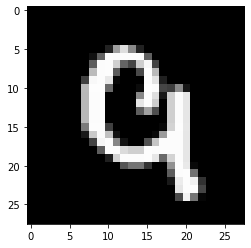

In [5]:

# MNIST img 보여주는 함수 정의
def plot_img(image):
  image = image.numpy()[0]
  mean = 0.1307
  std = 0.3081
  image = ((mean * image) + std)
  plt.imshow(image,cmap='gray')

plot_img(sample_data[0][2])
# MNIST 이미지 화면 출력

In [6]:
# 신경망 구성 : maxpool2d -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> FC
class Net(nn.Module):
  def __init__(self ):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

# 전방 연산 함수 정의
  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    
    return F.log_softmax(x,dim=1)

In [7]:
# model 및 cuda 설정
model = Net()
if is_cuda:
  model.cuda()

In [8]:
# SGD optimizer
optimizer = optim.SGD(model.parameters(),lr=0.01)
data , target = next(iter(train_loader))
output = model(Variable(data.cuda()))


print("output size : ", output.size())
print("target size : ", target.size())

output size :  torch.Size([32, 10])
target size :  torch.Size([32])


In [9]:
# 모델 학습 및 검증하는 함수 정의
def fit(epoch,model,data_loader,phase='training',volatile=False):
  if phase == 'training':
    model.train()

  if phase == 'validation':
    model.eval()
    volatile=True
  running_loss = 0.0
  running_correct = 0
  
  for batch_idx , (data,target) in enumerate(data_loader):
    if is_cuda:
      data,target = data.cuda(),target.cuda()
    
    data , target = Variable(data,volatile),Variable(target)
    
    if phase == 'training':
      optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output,target)
    
    running_loss += F.nll_loss(output,target,size_average=False).data
    preds = output.data.max(dim=1,keepdim=True)[1]
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
    
    if phase == 'training':
      loss.backward()
      optimizer.step()
  
  loss = running_loss/len(data_loader.dataset)
  accuracy = 100. * running_correct/len(data_loader.dataset)
  
  print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
  return loss, accuracy


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.63 and training accuracy is 47957/60000     79.93
validation loss is  0.15 and validation accuracy is 9513/10000     95.13
training loss is   0.2 and training accuracy is 56600/60000     94.33
validation loss is 0.094 and validation accuracy is 9700/10000      97.0
training loss is  0.15 and training accuracy is 57303/60000      95.5
validation loss is 0.083 and validation accuracy is 9729/10000     97.29
training loss is  0.13 and training accuracy is 57730/60000     96.22
validation loss is 0.065 and validation accuracy is 9785/10000     97.85
training loss is  0.12 and training accuracy is 57917/60000     96.53
validation loss is 0.057 and validation accuracy is 9808/10000     98.08
training loss is   0.1 and training accuracy is 58174/60000     96.96
validation loss is 0.046 and validation accuracy is 9845/10000     98.45
training loss is 0.096 and training accuracy is 58273/60000     97.12
validation loss is 0.049 and validation accuracy is 9834/10000     98.34

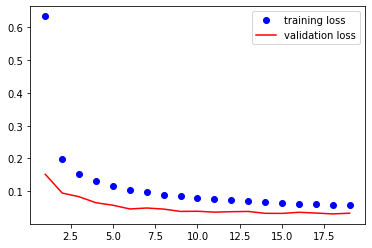

In [10]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]

# 20번 반복
for epoch in range(1,20):
  epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training', volatile=False)
  val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation', volatile=False)
  train_losses.append(epoch_loss)
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

# train, validation loss 구하기
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

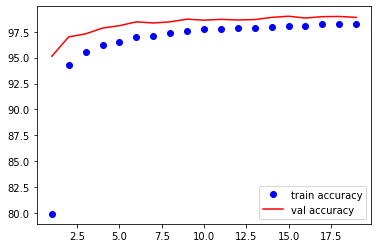

In [11]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()